In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE 
from lightgbm import LGBMClassifier
from google.colab import output, files
output.clear()

In [ ]:
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv
output.clear()

In [ ]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

In [ ]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


# Анализ

Чуть меньше половины данных в каждой колонке в файле train с приставой ab и ar содержат пропуски. Интересно то, что именно у этих колонок тип является float, то есть они точно являются непрерывными переменными. 

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     32395 non-null  int64  
 1   ar_revenue                    17250 non-null  float64
 2   ar_total_expenses             17250 non-null  float64
 3   ar_sale_cost                  17250 non-null  float64
 4   ar_selling_expenses           17250 non-null  float64
 5   ar_management_expenses        17250 non-null  float64
 6   ar_sale_profit                17250 non-null  float64
 7   ar_balance_of_rvns_and_expns  17250 non-null  float64
 8   ar_profit_before_tax          17250 non-null  float64
 9   ar_taxes                      17250 non-null  float64
 10  ar_other_profit_and_losses    17250 non-null  float64
 11  ar_net_profit                 17250 non-null  float64
 12  ab_immobilized_assets         17250 non-null  float64
 13  a

Посмотрим количество строк с пропущенными значениями. Делаем ввывод о том, что чуть меньше половины данных содержат пропуски, начиная с ar_revenue и заканчивая на ab_other_borrowings.

In [ ]:
len(train_df) - train_df.isna().any(axis=1).sum()

17250

В тестовой выборке ситуация аналогичная, но перекос в другую сторону, чуть больше половины данных содержат пропуски в указанных выше колонках.

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     200 non-null    int64  
 1   ar_revenue                    82 non-null     float64
 2   ar_total_expenses             82 non-null     float64
 3   ar_sale_cost                  82 non-null     float64
 4   ar_selling_expenses           82 non-null     float64
 5   ar_management_expenses        82 non-null     float64
 6   ar_sale_profit                82 non-null     float64
 7   ar_balance_of_rvns_and_expns  82 non-null     float64
 8   ar_profit_before_tax          82 non-null     float64
 9   ar_taxes                      82 non-null     float64
 10  ar_other_profit_and_losses    82 non-null     float64
 11  ar_net_profit                 82 non-null     float64
 12  ab_immobilized_assets         82 non-null     float64
 13  ab_mo

In [ ]:
len(test_df) - test_df.isna().any(axis=1).sum()

82

Одна колонка в данных имеет тип object. Это ранговая переменная, её надо закодировать.

In [ ]:
train_df['ul_staff_range'].value_counts()

[1-100]      29281
(100-500]     2757
> 500          357
Name: ul_staff_range, dtype: int64

In [ ]:
names_str = dict(train_df['ul_staff_range'].value_counts()).keys()
names_int = [1, 2, 3]
train_df = train_df.replace(names_str, names_int)

Посмотрим на уникальные значения для каждой колонки. ul_systematizing_flg везде равен 0. Значит все компании в нашей выборке не являются системообразущими компаниями. Относительно других компаний наша будущая модель не сможет и не должна делать какие либо выводы. Эту колонку можно удалить поскольку ни о какой корреляции речи не идёт. 

In [ ]:
train_df.nunique()

record_id                       32395
ar_revenue                      12893
ar_total_expenses               12779
ar_sale_cost                    12664
ar_selling_expenses              1994
ar_management_expenses           1093
ar_sale_profit                   7163
ar_balance_of_rvns_and_expns     5063
ar_profit_before_tax             6526
ar_taxes                         2247
ar_other_profit_and_losses        595
ar_net_profit                    6231
ab_immobilized_assets            3498
ab_mobile_current_assets        11222
ab_inventory                     9143
ab_accounts_receivable           8283
ab_other_current_assets          1210
ab_cash_and_securities           3677
ab_losses                        6175
ab_own_capital                   9090
ab_borrowed_capital             10261
ab_long_term_liabilities         2294
ab_short_term_borrowing          4896
ab_accounts_payable              8797
ab_other_borrowings              1437
bus_age                           315
ogrn_age    

In [ ]:
pd.DataFrame(train_df.apply(pd.unique)).rename(columns={0:'Unique values'})

,Unique values
record_id,"[7, 13, 18, 22, 23, 24, 30, 37, 38, 40, 54, 57..."
ar_revenue,"[52996000.0, nan, 32049000.0, 16458000.0, 1254..."
ar_total_expenses,"[48344000.0, nan, 29568000.0, 14935000.0, 1226..."
ar_sale_cost,"[48344000.0, nan, 29568000.0, 14935000.0, 1226..."
ar_selling_expenses,"[0.0, nan, 16442000.0, 29191000.0, 50000.0, 21..."
ar_management_expenses,"[0.0, nan, 1242000.0, 78000.0, 37161000.0, 386..."
ar_sale_profit,"[4652000.0, nan, 2481000.0, 1523000.0, 2777000..."
ar_balance_of_rvns_and_expns,"[-2608000.0, nan, -260000.0, -274000.0, -63000..."
ar_profit_before_tax,"[2044000.0, nan, 2221000.0, 1249000.0, 2714000..."
ar_taxes,"[846000.0, nan, 302000.0, 538000.0, 579000.0, ..."


In [ ]:
train_df.drop('ul_systematizing_flg', axis=1, inplace=True)

Посмотрим на статистики переменных с типом float. Как минимум 75% компаний имеют 0 условных единиц цены в качестве общих расходов за последний год, себестоимость продаж, прочиx доходов и расходов и в других переменных. При этом среднее в этих переменных сильно отличаеться от нуля.

In [ ]:
train_df.describe(include='float64')

,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,ul_capital_sum
count,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,1.725000e+04,3.239500e+04
mean,8.153776e+07,7.678474e+07,7.320328e+07,2.499198e+06,1.082263e+06,4.753016e+06,-6.424773e+05,4.110538e+06,4.188071e+05,3.937304e+04,3.731104e+06,9.007101e+06,3.044379e+07,1.627389e+07,1.336024e+07,8.096597e+05,1.610857e+06,3.307750e+06,1.911815e+07,2.419023e+07,3.149311e+06,4.983973e+06,1.508316e+07,9.737877e+05,1.366509e+06
std,1.274402e+08,1.227227e+08,1.156651e+08,1.231798e+07,7.848929e+06,1.941027e+07,6.014715e+06,1.938021e+07,1.565298e+06,4.843389e+05,1.902355e+07,3.642723e+07,6.331020e+07,3.729649e+07,3.851823e+07,8.222404e+06,1.067265e+07,8.895007e+06,4.603456e+07,5.917809e+07,2.764231e+07,1.359236e+07,3.793929e+07,1.493730e+07,1.502438e+07
min,0.000000e+00,-7.019840e+08,-5.072780e+08,-3.542900e+07,-1.921670e+08,-9.210000e+07,-7.581800e+07,-5.946600e+07,-1.681000e+07,-1.034000e+07,-4.778100e+07,0.000000e+00,0.000000e+00,0.000000e+00,-1.160400e+07,-3.413000e+06,0.000000e+00,-4.780300e+07,-7.501000e+07,0.000000e+00,-3.068000e+06,-2.700000e+06,0.000000e+00,-2.500000e+05,0.000000e+00
25%,1.019950e+07,9.130250e+06,8.844000e+06,0.000000e+00,0.000000e+00,2.112500e+05,-9.400000e+05,1.420000e+05,0.000000e+00,0.000000e+00,1.010000e+05,0.000000e+00,2.854500e+06,8.100000e+05,4.722500e+05,0.000000e+00,4.100000e+04,9.400000e+04,4.532500e+05,1.634000e+06,0.000000e+00,0.000000e+00,6.722500e+05,0.000000e+00,1.000000e+04
50%,3.233500e+07,2.970350e+07,2.840800e+07,0.000000e+00,0.000000e+00,1.231500e+06,-1.260000e+05,8.500000e+05,4.100000e+04,0.000000e+00,7.040000e+05,0.000000e+00,1.109450e+07,4.714500e+06,3.028500e+06,0.000000e+00,2.640000e+05,6.730000e+05,3.528000e+06,7.231000e+06,0.000000e+00,3.610000e+05,3.678000e+06,0.000000e+00,1.000000e+04
75%,8.887675e+07,8.309500e+07,7.991425e+07,0.000000e+00,0.000000e+00,4.574750e+06,0.000000e+00,3.543750e+06,2.910000e+05,0.000000e+00,3.176000e+06,3.490000e+05,3.423000e+07,1.754600e+07,1.200325e+07,0.000000e+00,1.188500e+06,3.025750e+06,1.760775e+07,2.541800e+07,0.000000e+00,3.816750e+06,1.424575e+07,0.000000e+00,3.000000e+04
max,7.946840e+08,7.949360e+08,7.624930e+08,2.746560e+08,3.023550e+08,1.434511e+09,1.584250e+08,1.481526e+09,5.420200e+07,3.979500e+07,1.485559e+09,1.630344e+09,3.175805e+09,2.890917e+09,1.711586e+09,3.336220e+08,1.271337e+09,2.470140e+08,1.739879e+09,3.349389e+09,2.919676e+09,3.223740e+08,1.820521e+09,1.251578e+09,1.584979e+09


В данных очень много выбросов.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


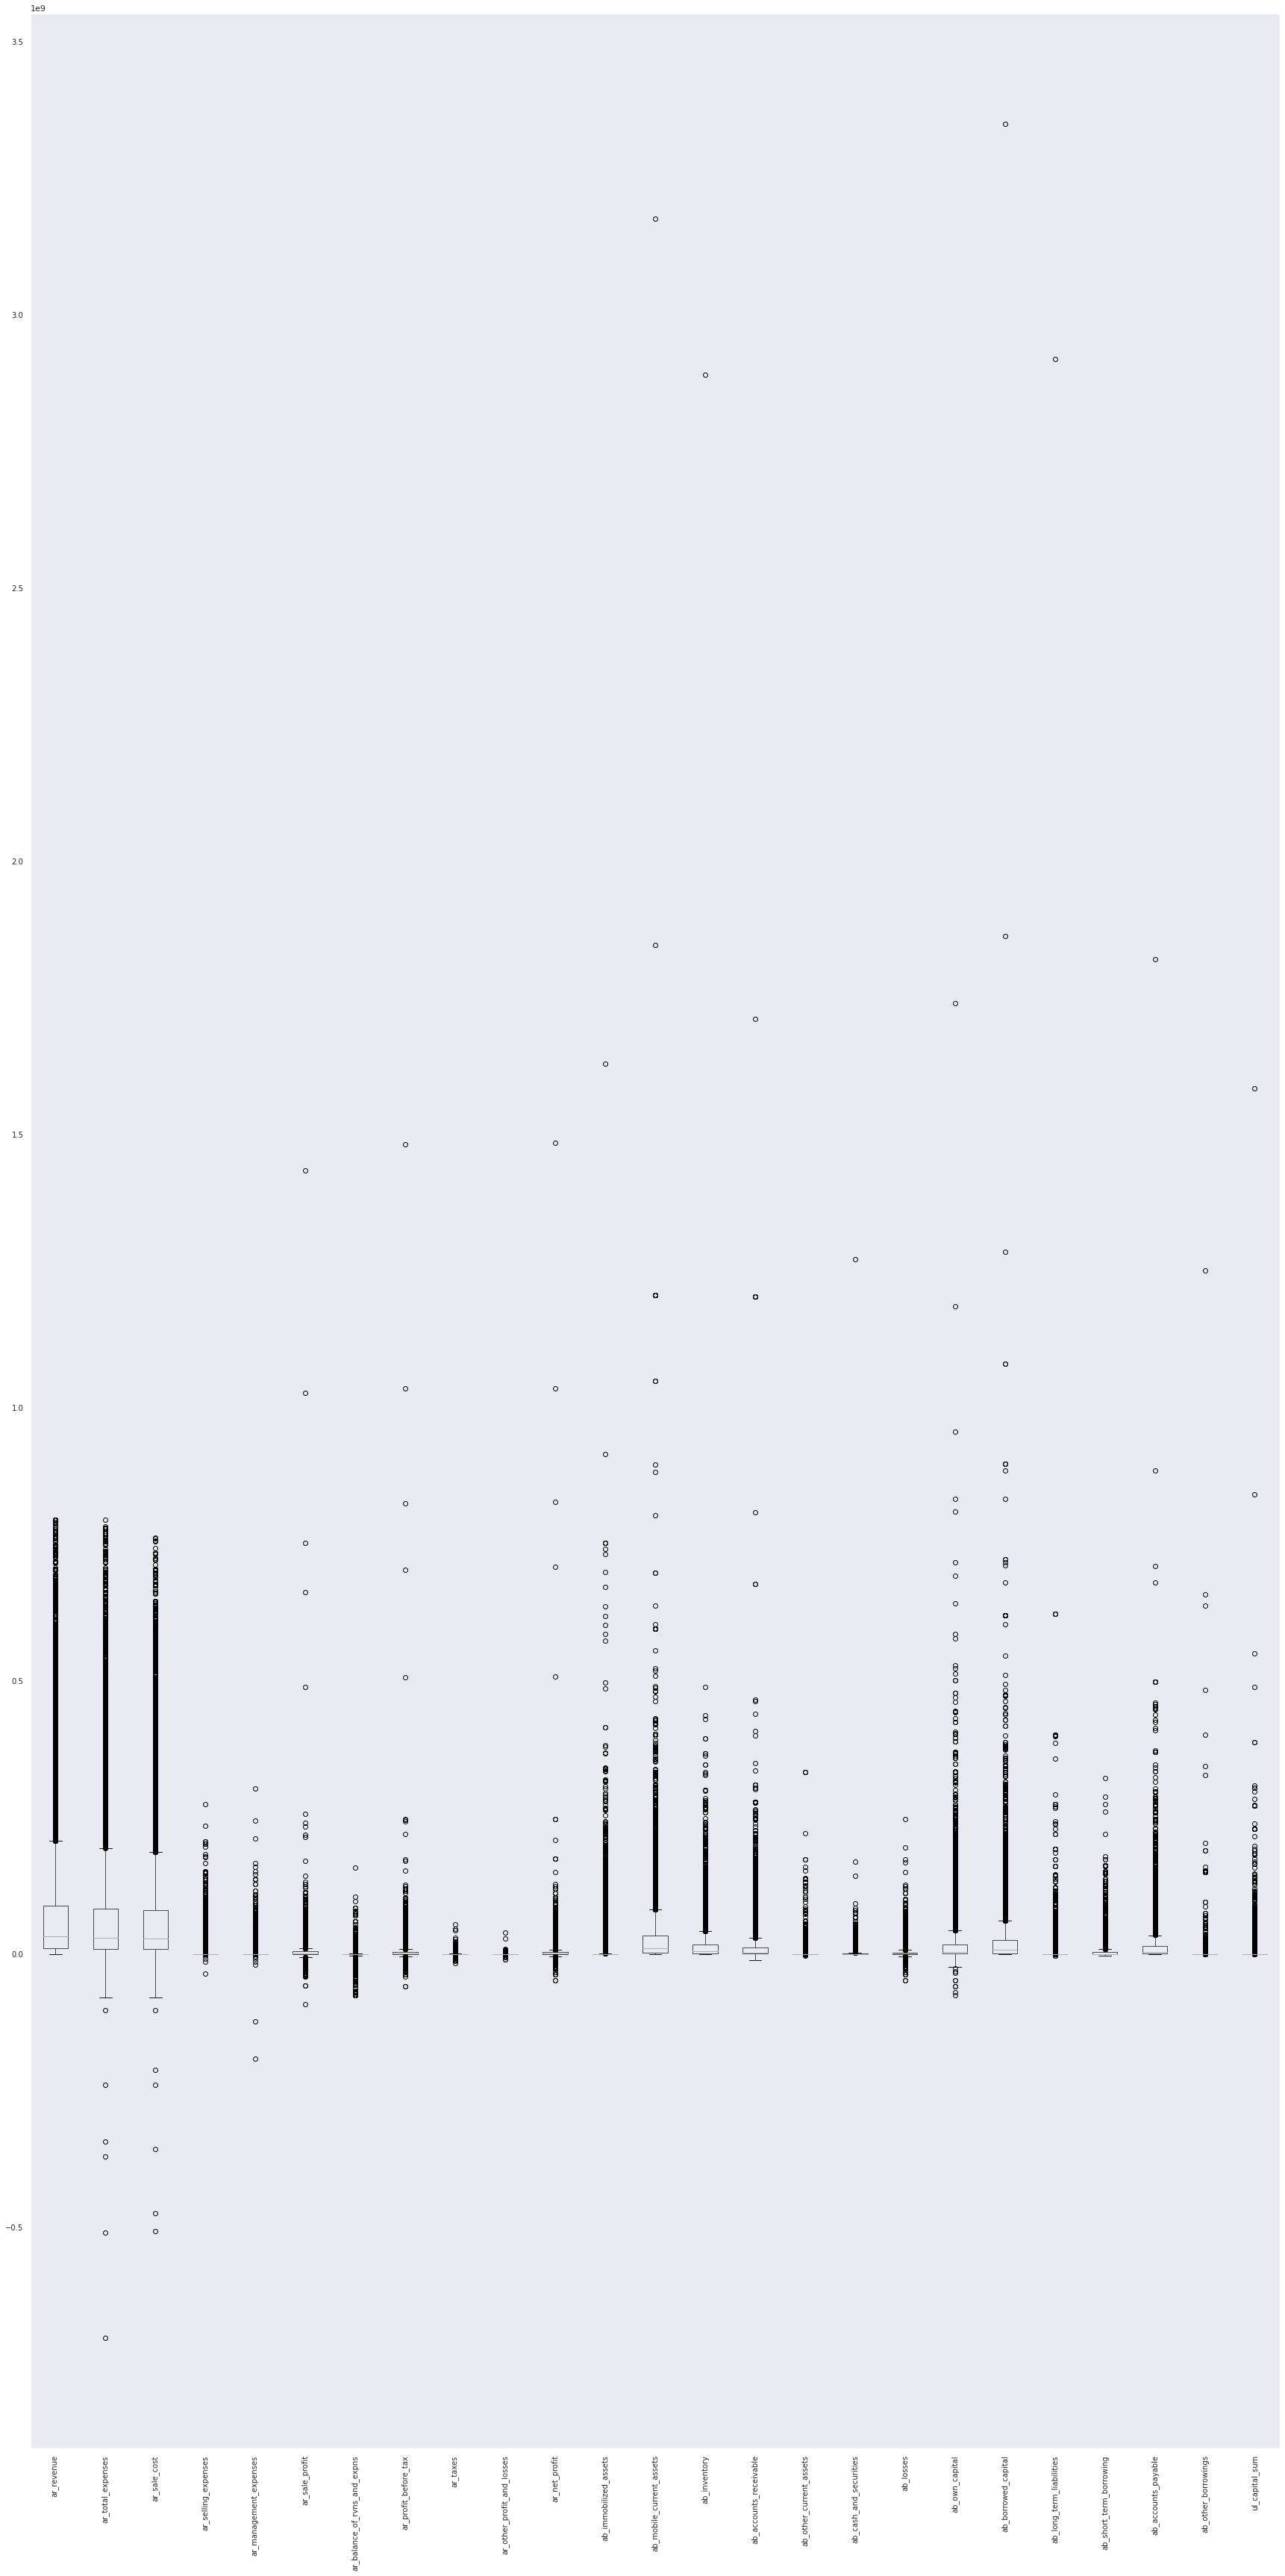

In [ ]:
train_df.select_dtypes(include='float64').boxplot(rot=90, grid=False, fontsize=10, figsize=(30, 60))

Посмотрим на распределение категориальных переменных. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f850de54790>,
      dtype=object)

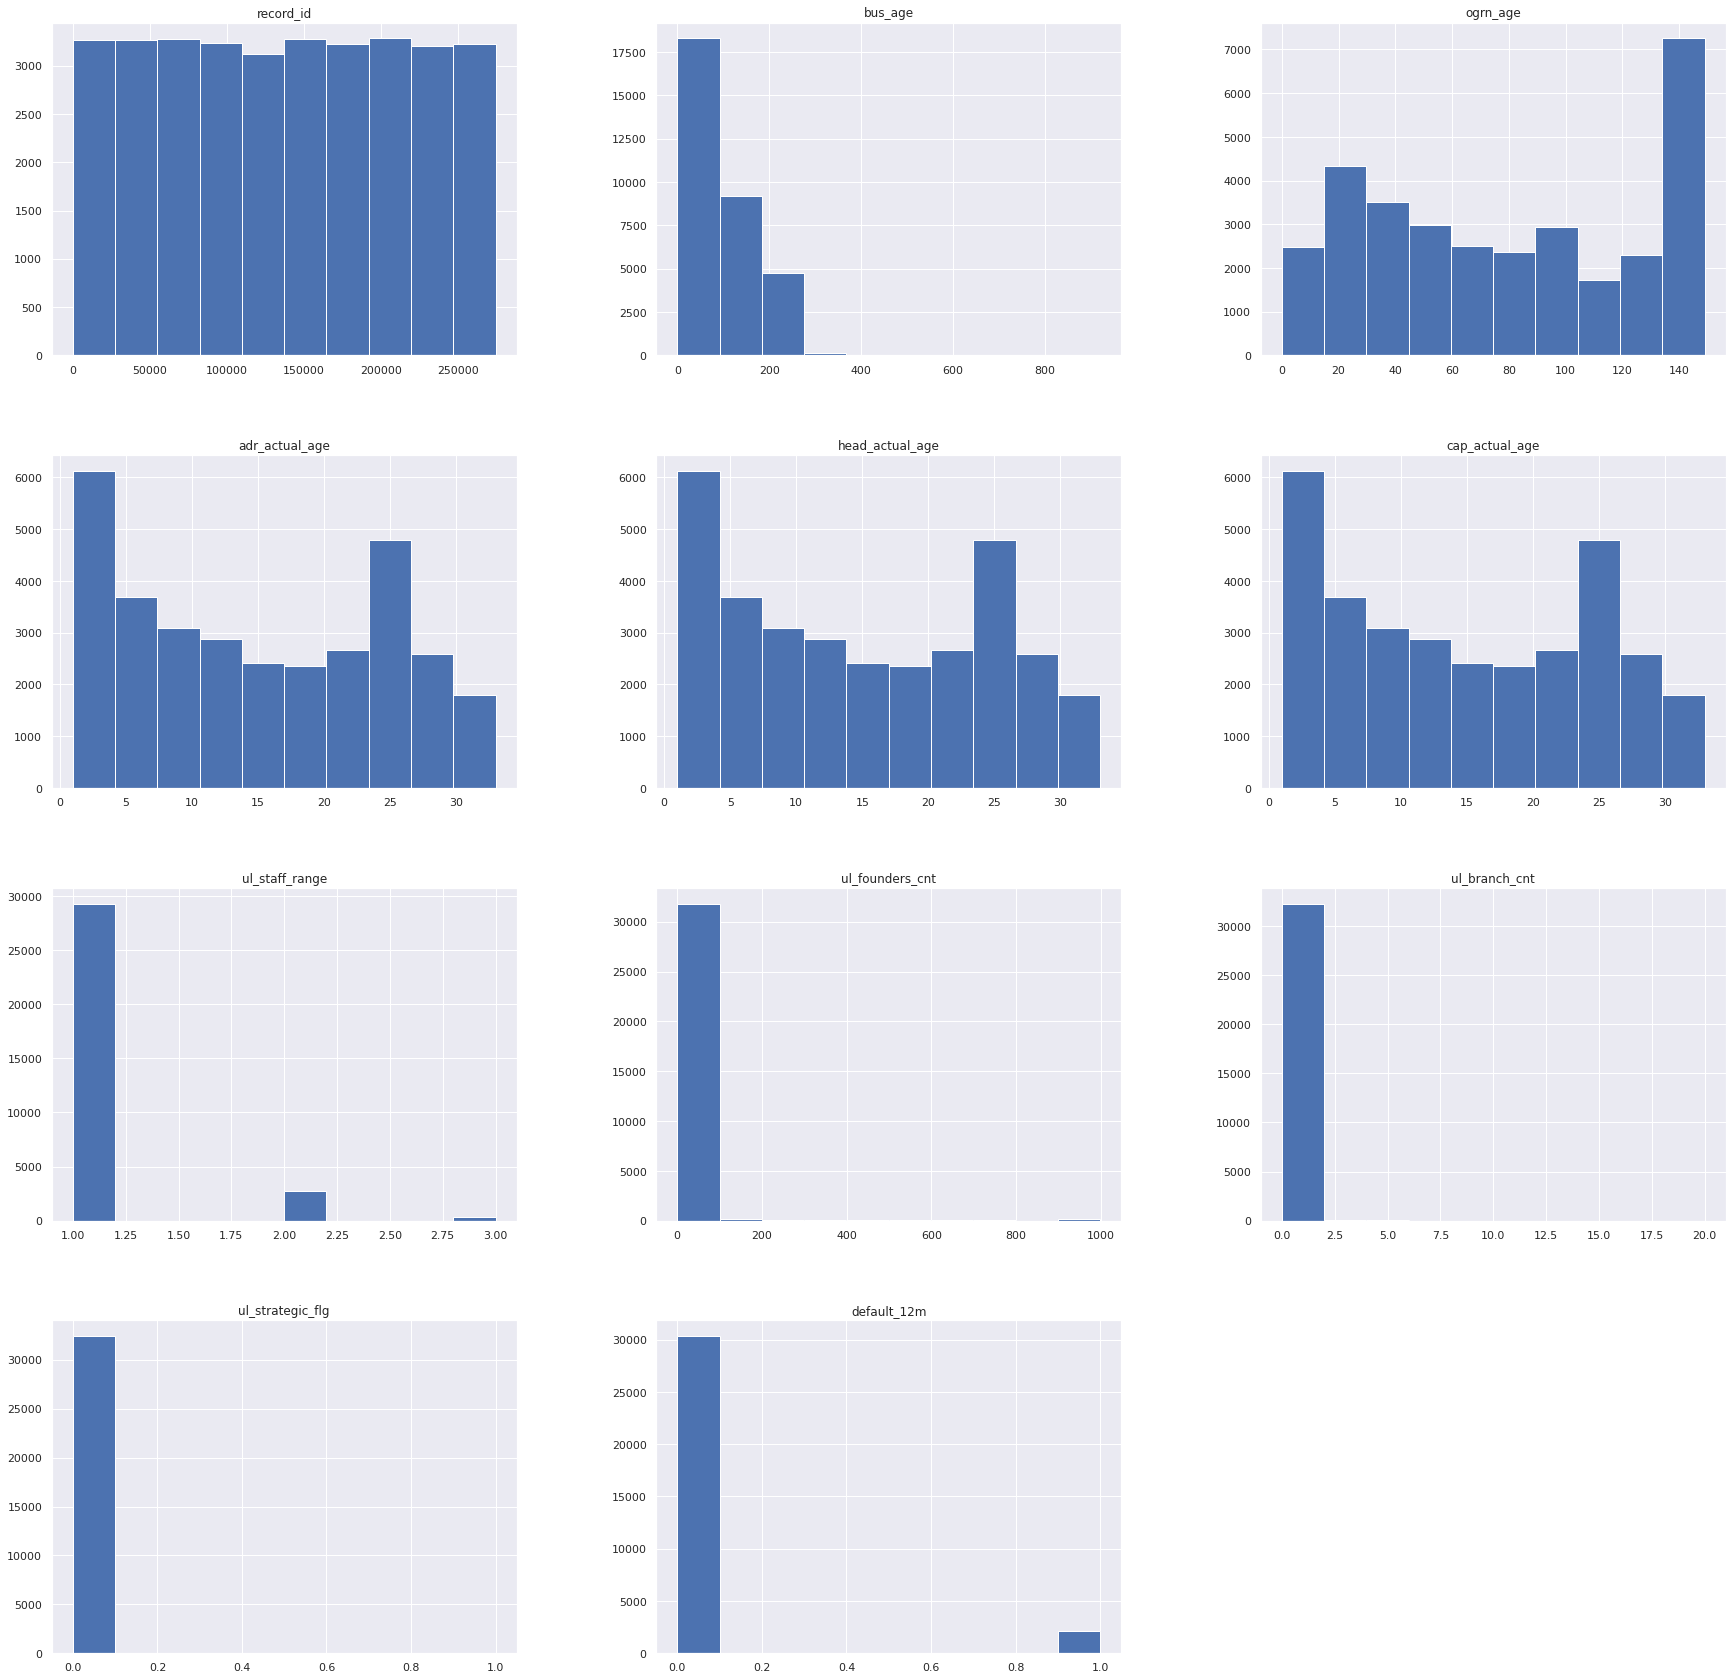

In [ ]:
train_df.select_dtypes(include='int64').hist(figsize=(30, 30))

Построим матрицу корреляций. Для некоторых пар коэффицент корреляции слишком большой (сильных отрицательных корреляций не наблюдается). При сильной корреляции двух признаков, один из них можно исключить. Забегая вперёд, нельзя исключать признак из коррелирующей пары для int и float, поскольку в дальнейшем будет две модели. Об этом можно не беспокиться, поскольку сильных корреляции для таких пар нет.

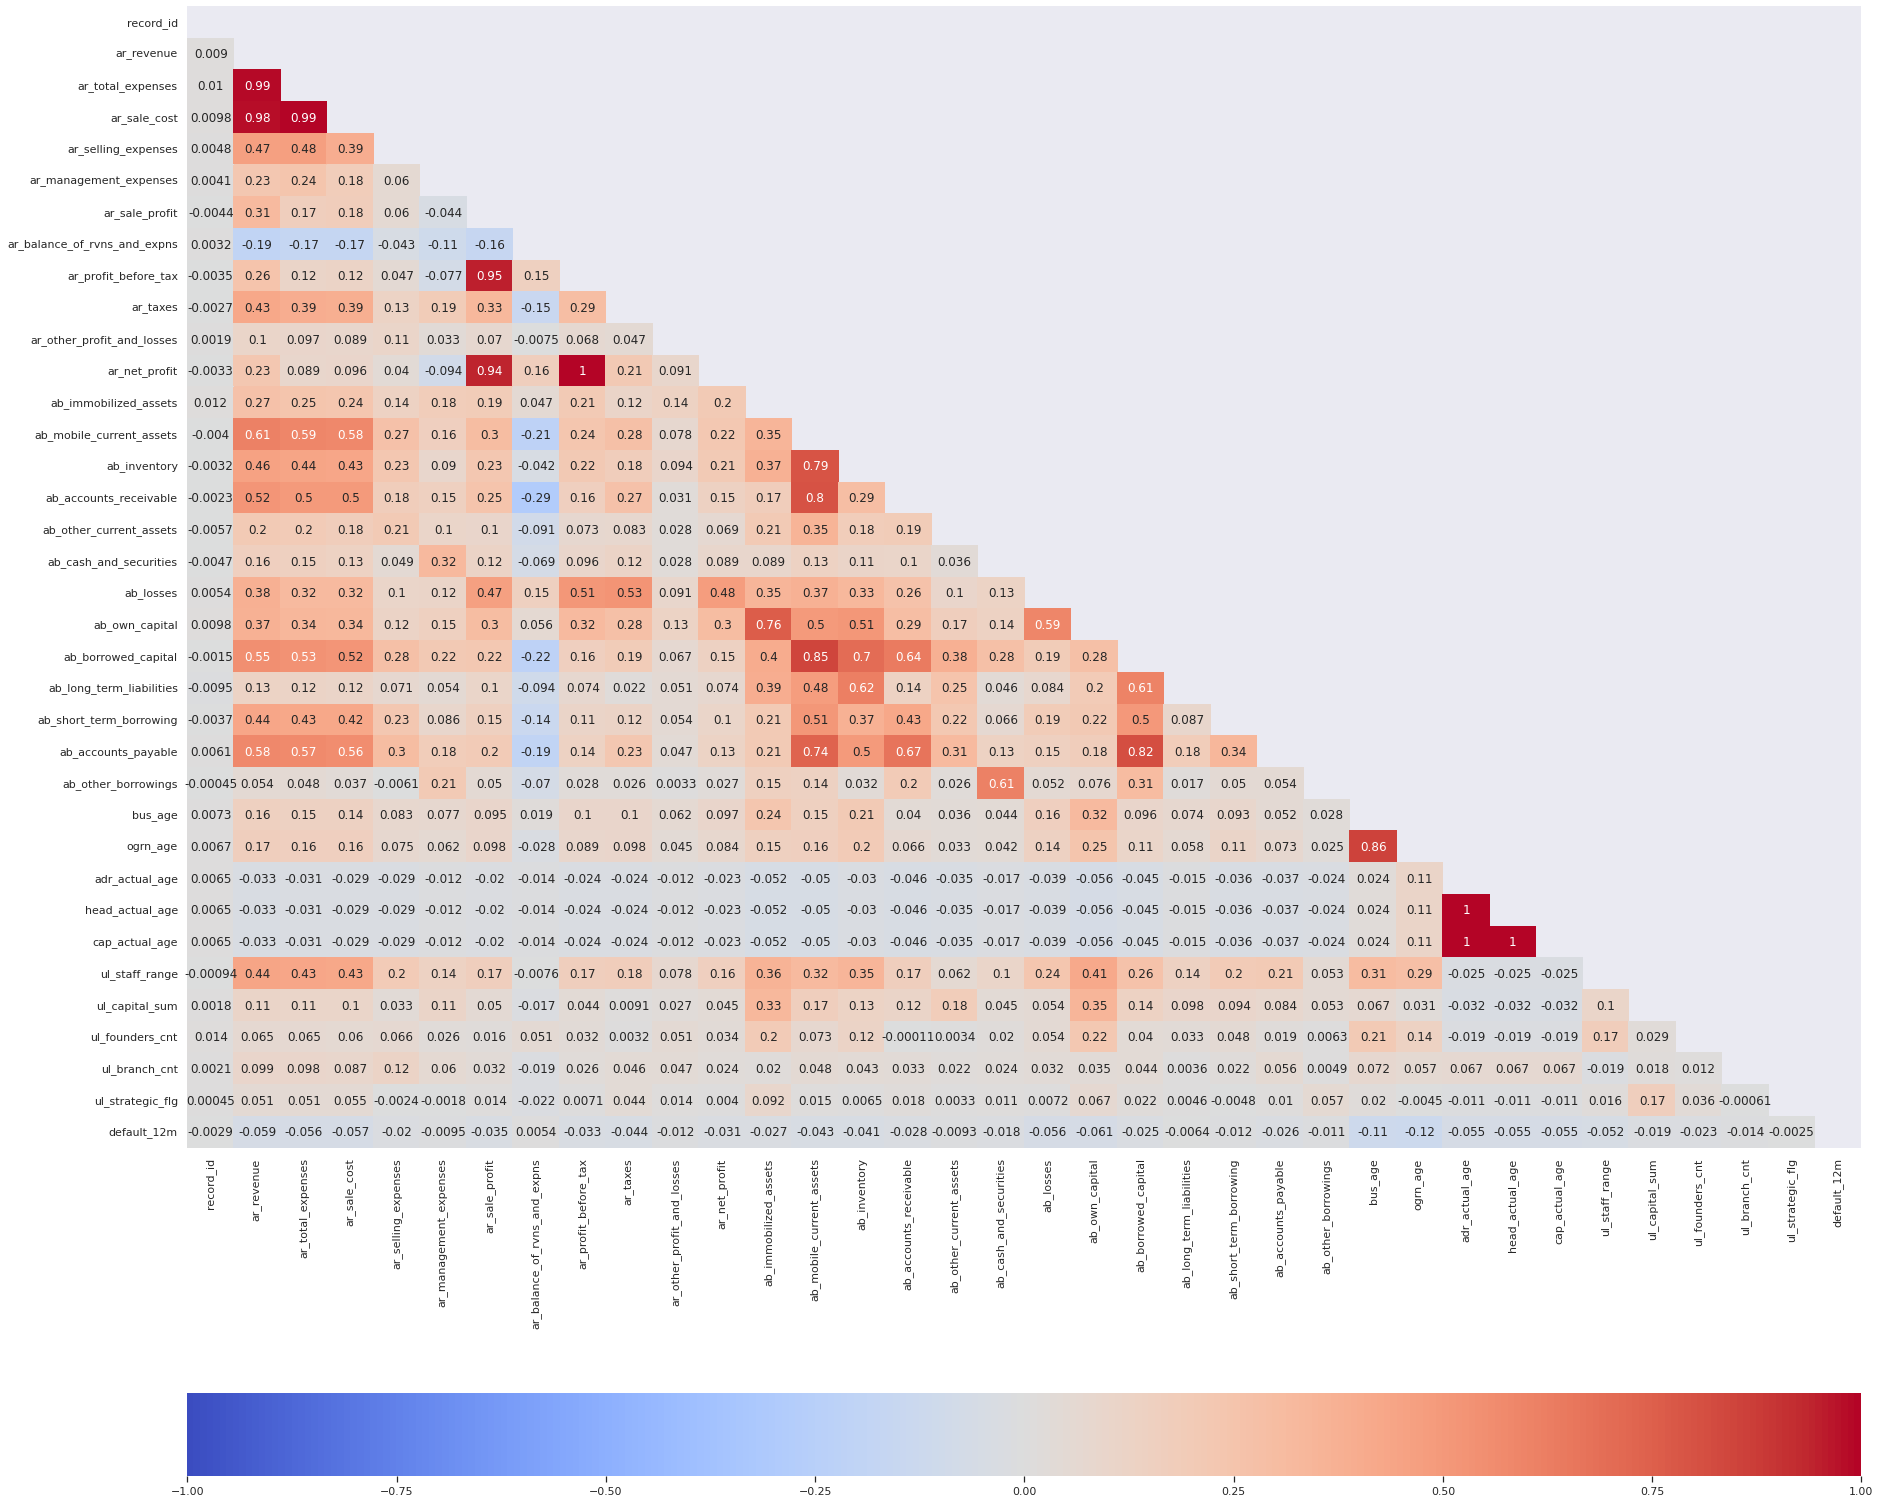

In [ ]:
sns.set(rc={'figure.figsize':(30, 30)})
matrix = np.triu(train_df.corr())
sns.heatmap(train_df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', cbar_kws= {'orientation': 'horizontal'}, mask=matrix)

Функция trimm_correlated оставляет только один признак из коррелирующей пары, для которой модуль коэффициента корреляции больше заданого значения.

In [ ]:
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

Я решил убирать один из тех признаков в коррелирующей паре для которой модуль коэффициента корреляции больше 0.9

In [ ]:
train_df = trimm_correlated(train_df, 0.9)

Матрица коэффициентов корреляции для обновленого train_df.

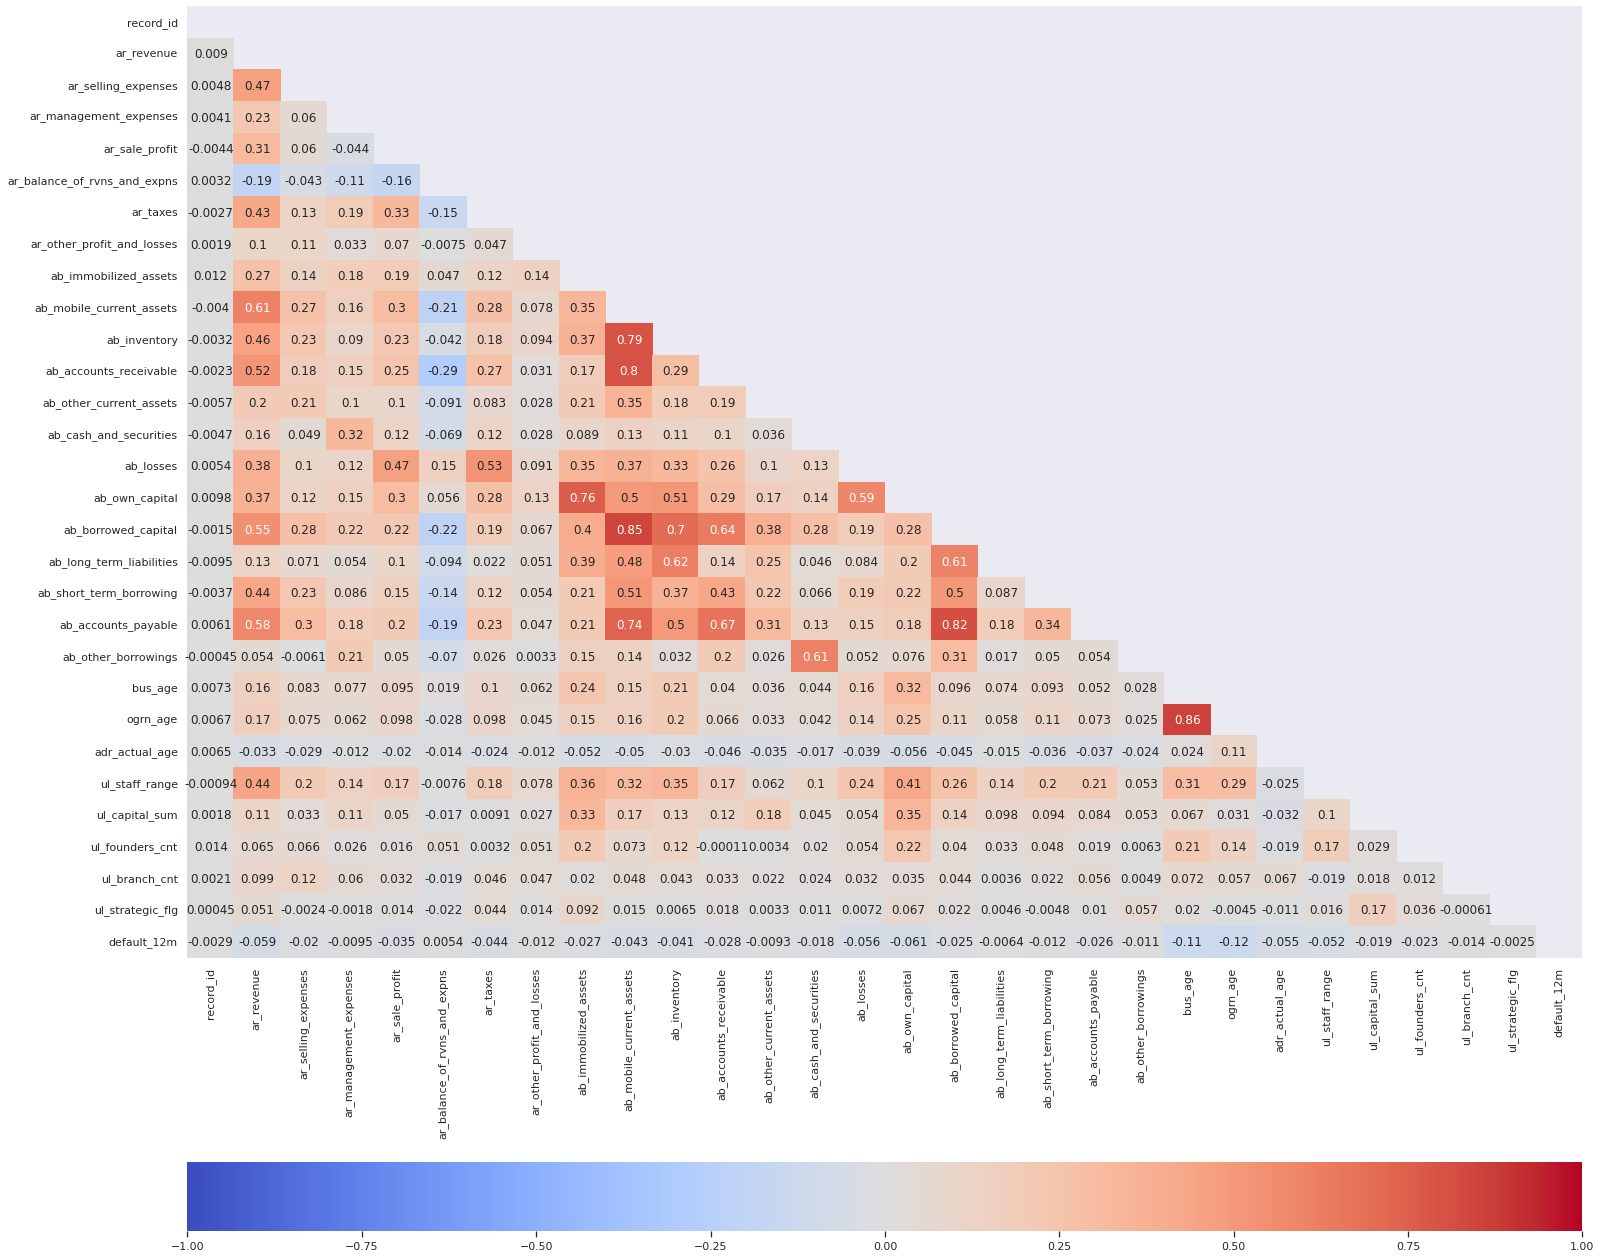

In [ ]:
matrix = np.triu(train_df.corr())
sns.set(rc={'figure.figsize':(25, 25)})
sns.heatmap(train_df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', cbar_kws= {'orientation': 'horizontal'}, mask=matrix)

Теперь разделим данные для двух моделей. train_df_part содержит данные, для которых в колонках ab ar пропущенны значения. train_df_full содержит строки без пропусков.

In [ ]:
features_df = train_df.copy(deep=True)
features_df = features_df.drop('record_id', axis=1)

features = features_df.columns.values.tolist()
# features список колонок, которые будут использоваться в тренировке модели для полных данных
# features = ['ar_revenue', 'ar_selling_expenses', 'ar_management_expenses', 'ar_sale_profit', 'ar_balance_of_rvns_and_expns', 'ar_taxes', 'ar_other_profit_and_losses', 'ab_immobilized_assets', 'ab_mobile_current_assets', 'ab_inventory', 'ab_accounts_receivable', 'ab_other_current_assets', 'ab_cash_and_securities', 'ab_losses', 'ab_own_capital', 'ab_borrowed_capital', 'ab_long_term_liabilities', 'ab_short_term_borrowing', 'ab_accounts_payable', 'ab_other_borrowings', 'bus_age', 'ogrn_age', 'adr_actual_age', 'ul_staff_range', 'ul_capital_sum', 'ul_founders_cnt', 'ul_branch_cnt', 'ul_strategic_flg', 'default_12m']

# not_nan_cols список колонок, которые будут использоваться для обучения модели для неполных данных
not_nan_cols = features_df.loc[:, features_df.notna().all()].columns.values.tolist()

In [ ]:
train_df_part = train_df[features][train_df['ar_revenue'].isnull()].loc[:, not_nan_cols]
train_df_full = train_df[features][~train_df['ar_revenue'].isnull()]

# Модель для полных данных

Мои идеи, исходя из анализа данных:

0. Модели должно быть две для полного и неполного набора данных, поскольку данные таким образом делятся практически поровну в тренировочной и тестовой выборках.

1. Оверсэмплинг. 
В SMOTE (Способ Передискретизации Синтезированных Меньшинств) мы создаём элементы в непосредственной близости от уже существующих в меньшем наборе. SMOTE не полагается на повторное использование ранее существующих наблюдений, вместо этого SMOTE создает новые (синтетические) наблюдения на основе наблюдений в наших данных. SMOTE не гарантирует получения более точных моделей, но сделав оверсэмплинг, я думаю, что мы сильно выиграем в стабильности.

2. Выбор модели. 
Мой выбор пал на lightgbm.LGBMClassifier, поскольку его работа основана на представлении данных как гистограммы. На начальном этапе эта модель делает бинизацию с количеством бинов subsample_for_bin=200000. Если уменьшить это значение, мы опять-таки должны выигрывать в стабильности.

3. Экспериметально попробовать подобрать гиперпараметры моделей.

Применение SMOTE, разбиение на обучающую и тестовую выборки, обучение классификатора

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train_df_full.drop('default_12m', axis=1), train_df_full['default_12m'])
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2,
                                                   random_state=42, shuffle=True)

clf_full = LGBMClassifier(subsample_for_bin=20, learning_rate=0.1, n_estimators=500)
clf_full.fit(X_train, y_train)

LGBMClassifier(n_estimators=500, subsample_for_bin=20)

Метрики модели. При подборе гиперпарметров я старался равновесно учитывать как метрики модели на тестовой выборке, так и финальный score.

In [ ]:
y_pred = clf_full.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

     class 0       0.96      0.91      0.94      3281
     class 1       0.92      0.96      0.94      3301

    accuracy                           0.94      6582
   macro avg       0.94      0.94      0.94      6582
weighted avg       0.94      0.94      0.94      6582

0.9377914721287806


# Модель для неполных данных

Применение SMOTE, разбиение на обучающую и тестовую выборки, обучение классификатора

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train_df_part.drop('default_12m', axis=1), train_df_part['default_12m'])
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2,
                                                    random_state=42, shuffle=True)

clf_part = LGBMClassifier(subsample_for_bin=20, learning_rate=0.01, n_estimators=300)
clf_part.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, n_estimators=300, subsample_for_bin=20)

Метрики модели 

In [ ]:
y_pred = clf_part.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

     class 0       0.69      0.57      0.63      2794
     class 1       0.63      0.74      0.68      2746

    accuracy                           0.66      5540
   macro avg       0.66      0.66      0.66      5540
weighted avg       0.66      0.66      0.65      5540

0.6579405405715401


# Предсказание

In [ ]:
test_df = pd.read_csv('PD-data-test.csv', sep=';')
test_df = test_df[['record_id', 'ar_revenue', 'ar_selling_expenses', 'ar_management_expenses', 'ar_sale_profit', 'ar_balance_of_rvns_and_expns', 'ar_taxes', 'ar_other_profit_and_losses', 'ab_immobilized_assets', 'ab_mobile_current_assets', 'ab_inventory', 'ab_accounts_receivable', 'ab_other_current_assets', 'ab_cash_and_securities', 'ab_losses', 'ab_own_capital', 'ab_borrowed_capital', 'ab_long_term_liabilities', 'ab_short_term_borrowing', 'ab_accounts_payable', 'ab_other_borrowings', 'bus_age', 'ogrn_age', 'adr_actual_age', 'ul_staff_range', 'ul_capital_sum', 'ul_founders_cnt', 'ul_branch_cnt', 'ul_strategic_flg']]
test_df = test_df.replace(names_str, names_int)

df_part = test_df[test_df['ar_revenue'].isnull()].loc[:, 'bus_age':]
df_part_id = test_df[test_df['ar_revenue'].isnull()]['record_id']
df_full = test_df[~test_df['ar_revenue'].isnull()]
df_full_id = test_df[~test_df['ar_revenue'].isnull()]['record_id']
df_full.drop('record_id',axis=1, inplace=True)

ans_part = dict(zip(df_part_id, clf_part.predict(np.array(df_part))))

ans_full = dict(zip(df_full_id, clf_full.predict(np.array(df_full))))
ans_dict = ans_part.copy()
ans_dict.update(ans_full)

answ_df = test_df[['record_id']]
answ_df['predict'] = answ_df['record_id']
answ_df['predict'] = answ_df['predict'].map(ans_dict)
answ_df = answ_df.rename(columns = {'record_id': 'id'})

answ_file = answ_df.to_csv('PD-submit.csv',index=False, sep=';')

files.download('PD-submit.csv') 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Итоговая оценка модели на сабмите сотавила 0.675 (14-17 места на лидерборде).